<a href="https://colab.research.google.com/github/domarps/neural-net-notepad/blob/master/cgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.examples.tutorials.mnist import input_data


In [57]:
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [58]:
X_dim, y_dim = mnist.train.images.shape[1], mnist.train.labels.shape[1] # X (image dimension), y (label dimension)
print(X_dim, y_dim)

784 10


In [0]:
Z_dim = 100
h_dim = 128
cnt = 0
lr = 1e-3
mini_batch = 64

In [0]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

In [0]:
""" ==================== GENERATOR ======================== """

Whx = xavier_init(size=[h_dim, X_dim])
bhx = torch.zeros(X_dim, requires_grad=True)

Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)
                  

def G(z, c):
    inputs = torch.cat([z, c], 1)
    h = nn.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = nn.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


  
""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)

def D(X, c):
  inputs = torch.cat([X, c], 1)
  h = nn.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1))
  y = nn.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
  return y

In [0]:
G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params

In [0]:
""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mini_batch, 1))
zeros_label = Variable(torch.zeros(mini_batch, 1))

In [64]:
for it in range(100000):
    # Sample data
    z = Variable(torch.randn(mini_batch, Z_dim))
    X, c = mnist.train.next_batch(mini_batch)
    X = Variable(torch.from_numpy(X))
    c = Variable(torch.from_numpy(c.astype('float32')))

    # Dicriminator forward-loss-backward-update
    G_sample = G(z, c)
    D_real = D(X, c)
    D_fake = D(G_sample, c)

    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    D_loss.backward()
    D_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    z = Variable(torch.randn(mini_batch, Z_dim))
    G_sample = G(z, c)
    D_fake = D(G_sample, c)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # Housekeeping - reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.numpy(), G_loss.data.numpy()))

        c = np.zeros(shape=[mini_batch, y_dim], dtype='float32')
        c[:, np.random.randint(0, 10)] = 1.
        c = Variable(torch.from_numpy(c))
        samples = G(z, c).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('out/'):
            os.makedirs('out/')

        plt.savefig('out/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
        cnt += 1
        plt.close(fig)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iter-0; D_loss: 1.1377404928207397; G_loss: 2.808150053024292
Iter-1000; D_loss: 0.009211495518684387; G_loss: 6.816244602203369
Iter-2000; D_loss: 0.023438237607479095; G_loss: 5.90328311920166
Iter-3000; D_loss: 0.05616011098027229; G_loss: 5.634189128875732
Iter-4000; D_loss: 0.21671143174171448; G_loss: 4.747138023376465
Iter-5000; D_loss: 0.4136508107185364; G_loss: 3.7933852672576904
Iter-6000; D_loss: 0.2702176570892334; G_loss: 4.403937816619873
Iter-7000; D_loss: 0.5207614898681641; G_loss: 3.522796392440796
Iter-8000; D_loss: 0.570395827293396; G_loss: 2.303628444671631
Iter-9000; D_loss: 0.490307480096817; G_loss: 3.1399171352386475
Iter-10000; D_loss: 0.7737541198730469; G_loss: 2.6028387546539307
Iter-11000; D_loss: 0.5697714686393738; G_loss: 2.5529043674468994
Iter-12000; D_loss: 0.8379417657852173; G_loss: 2.70797061920166
Iter-13000; D_loss: 0.6329725980758667; G_loss: 2.4610581398010254
Iter-14000; D_loss: 0.7652851343154907; G_loss: 2.2341251373291016
Iter-15000; D_l

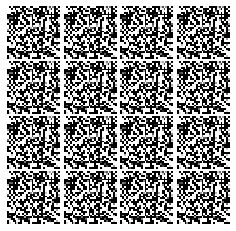

In [65]:
from IPython.display import Image
Image('out/126.png')

In [66]:
! ls out/

000.png  015.png  030.png  045.png  060.png  075.png  090.png  105.png	120.png
001.png  016.png  031.png  046.png  061.png  076.png  091.png  106.png	121.png
002.png  017.png  032.png  047.png  062.png  077.png  092.png  107.png	122.png
003.png  018.png  033.png  048.png  063.png  078.png  093.png  108.png	123.png
004.png  019.png  034.png  049.png  064.png  079.png  094.png  109.png	124.png
005.png  020.png  035.png  050.png  065.png  080.png  095.png  110.png	125.png
006.png  021.png  036.png  051.png  066.png  081.png  096.png  111.png	126.png
007.png  022.png  037.png  052.png  067.png  082.png  097.png  112.png
008.png  023.png  038.png  053.png  068.png  083.png  098.png  113.png
009.png  024.png  039.png  054.png  069.png  084.png  099.png  114.png
010.png  025.png  040.png  055.png  070.png  085.png  100.png  115.png
011.png  026.png  041.png  056.png  071.png  086.png  101.png  116.png
012.png  027.png  042.png  057.png  072.png  087.png  102.png  117.png
013.png  028.png  043